In [97]:
from music21 import *
import pandas as pd
import glob
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.optimizers import Adam

In [98]:
%matplotlib inline

In [99]:
path = '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/bach_teste'

In [100]:
files = glob.glob('{}/*.mid*'.format(path))

In [101]:
files

['/home/eurismar/notebooks/c-rnn-gan/datadir/classical/bach_teste/air.mid',
 '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/bach_teste/2467lvbminuet.mid']

In [139]:
coluna1 = []
coluna2 = []
midi = converter.parse(files[1])
part0 = midi[0]
melodia = part0.getElementsByClass(note.Note)
notas = melodia.getElementsByClass(note.Note)
for nota in notas:
    coluna1.append(nota.midi)
    coluna2.append(nota.duration.quarterLength)

In [140]:
df = pd.DataFrame({"nota":coluna1,
                   "duracao":coluna2})

In [141]:
df.head()

,duracao,nota
0,0.75,69
1,1,74
2,1,73
3,0,74
4,0,76


In [142]:
df.tail()

,duracao,nota
831,0.25,86
832,0.25,88
833,1,90
834,1,88
835,0.5,86


In [143]:
df.describe()

,nota
count,836.000000
mean,78.509569
std,5.602066
min,62.000000
25%,74.000000
50%,79.000000
75%,83.000000
max,93.000000


In [144]:
df['nota'].unique()

array([69, 74, 73, 76, 78, 79, 81, 80, 85, 88, 93, 91, 77, 82, 83, 86, 90,
       84, 71, 67, 62, 72, 66, 87, 89])

In [145]:
df['duracao'].unique()

array([0.75, 1.0, 0.0, 0.25, 1.75, 2.0, 0.5, 1.25, Fraction(1, 3)],
      dtype=object)

In [146]:
mlb = MultiLabelBinarizer()

In [147]:
mlb.fit(df.values)

MultiLabelBinarizer(classes=None, sparse_output=False)

In [148]:
classes = mlb.classes_

In [149]:
classes

array([0.0, 0.25, Fraction(1, 3), 0.5, 0.75, 1.0, 1.25, 1.75, 2.0, 62, 66,
       67, 69, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 93], dtype=object)

In [150]:
classes.shape

(34,)

In [151]:
labels = mlb.transform(df.values)

In [152]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [153]:
labels.shape

(836, 34)

In [154]:
array_notas = df['nota'].values.astype(int)

In [155]:
array_notas.shape

(836,)

In [156]:
array_duracao = df['duracao'].values.astype(float)

In [157]:
scaler = StandardScaler()
rawX = scaler.fit_transform(df.values)

/home/eurismar/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [158]:
rawX

array([[ 0.85830922, -1.69852734],
       [ 1.47055027, -0.80546517],
       [ 1.47055027, -0.9840776 ],
       ...,
       [ 1.47055027,  2.05233379],
       [ 1.47055027,  1.69510892],
       [ 0.24606817,  1.33788405]])

In [159]:
scaler.inverse_transform(rawX[0])

array([ 0.75, 69.  ])

In [160]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, rawX.shape[0] - seq_length, 1):
	seq_in = rawX[i:i + seq_length]
	seq_out = labels[i + seq_length]
	dataX.append(seq_in)
	dataY.append(seq_out)
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

Total Patterns:  736


In [161]:
X = np.reshape(dataX, (len(dataX), seq_length, 2))
y = np.asarray(dataY)

In [162]:
X.shape

(736, 100, 2)

In [163]:
y.shape

(736, 34)

In [164]:
model = Sequential()
model.add(LSTM(256, input_shape=(seq_length, 2),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='sigmoid'))
adam = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=adam,metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100, 256)          265216    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 34)                8738      
Total params: 799,266
Trainable params: 799,266
Non-trainable params: 0
_________________________________________________________________
None


In [165]:
history = model.fit(X, y, epochs=10,batch_size=32, verbose=1, shuffle=False)

Epoch 1/10
736/736 [==============================] - 8s - loss: 0.4575 - acc: 0.7857     
Epoch 2/10
736/736 [==============================] - 8s - loss: 0.2068 - acc: 0.9404     
Epoch 3/10
736/736 [==============================] - 7s - loss: 0.1983 - acc: 0.9384     
Epoch 4/10
736/736 [==============================] - 7s - loss: 0.1930 - acc: 0.9409     
Epoch 5/10
736/736 [==============================] - 6s - loss: 0.1908 - acc: 0.9414     
Epoch 6/10
736/736 [==============================] - 6s - loss: 0.1917 - acc: 0.9410     
Epoch 7/10
736/736 [==============================] - 6s - loss: 0.1900 - acc: 0.9413     
Epoch 8/10
736/736 [==============================] - 6s - loss: 0.1909 - acc: 0.9414     
Epoch 9/10
736/736 [==============================] - 6s - loss: 0.1908 - acc: 0.9424     
Epoch 10/10
736/736 [==============================] - 6s - loss: 0.1893 - acc: 0.9407     


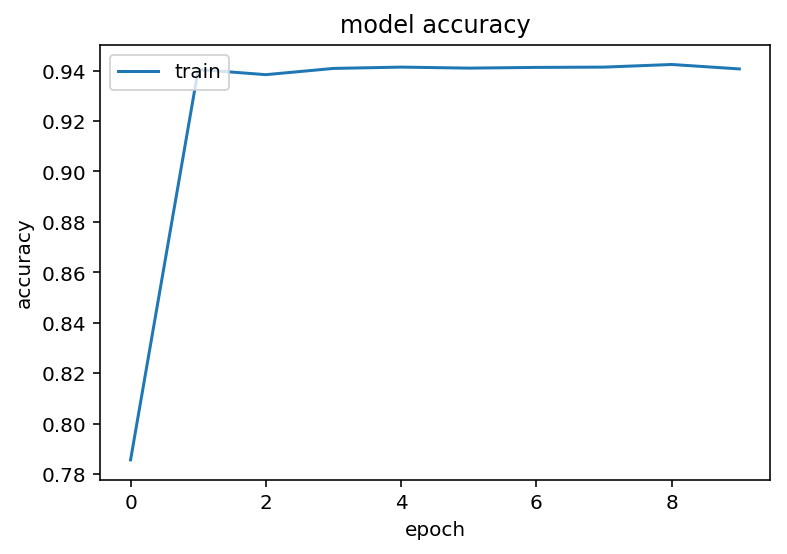

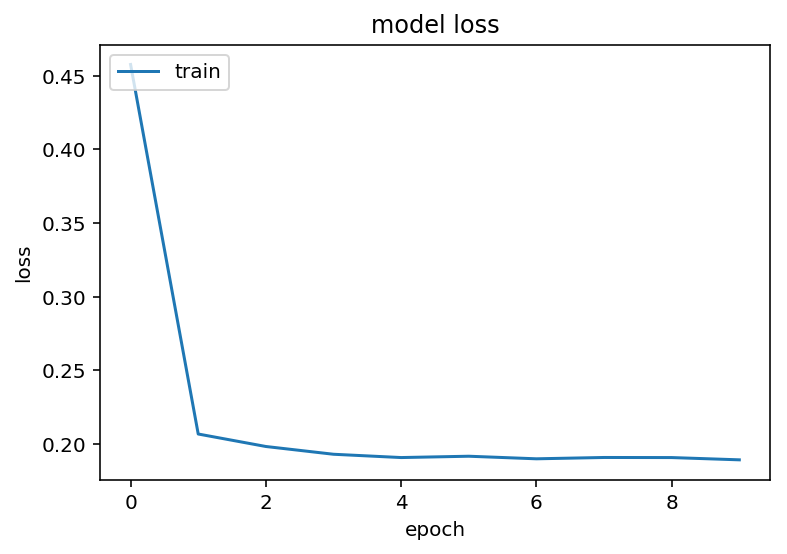

In [166]:

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **Prevendo somente uma label**

In [167]:
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
p = np.reshape(pattern, (1, len(pattern), 2))
prediction = model.predict(p, verbose=0)
idxs = np.argsort(prediction[0])[::-1][:2]
print('idxs:',idxs)
new_pattern = [mlb.classes_[idxs[0]],mlb.classes_[idxs[1]]]
print('antes sort:',new_pattern)
new_pattern.sort()
print('depois sort:',new_pattern)
t = np.asarray(new_pattern)
t1 = t.reshape(1,2)
print(t1)
pt = scaler.transform(t1)
print(pt)

idxs: [ 1 20]
antes sort: [0.25, 79]
depois sort: [0.25, 79]
[[ 0.25 79.  ]]
[[-0.36617288  0.08759701]]


## **Prevendo uma sequencia**

In [168]:
len(dataX)

736

In [169]:
start = np.random.randint(0, len(dataX)-1)
print(start)
pattern = dataX[start]
for i in range(10):
    p = np.reshape(pattern, (1, len(pattern), 2))
    prediction = model.predict(p, verbose=0)
    idxs = np.argsort(prediction[0])[::-1][:2]
    new_pattern = [mlb.classes_[idxs[0]],mlb.classes_[idxs[1]]]
    new_pattern.sort()
    t = np.asarray(new_pattern).reshape(1,2)
    pt = scaler.transform(t)
    a = np.concatenate((pattern,pt))
    b = a[1:len(a)]
    pattern = b

523


In [170]:
inverso = scaler.inverse_transform(pattern)

In [171]:
sc = stream.Score()
for i in inverso:
    n = note.Note(midi=i[1], quarterLength=i[0])
    sc.append(n)

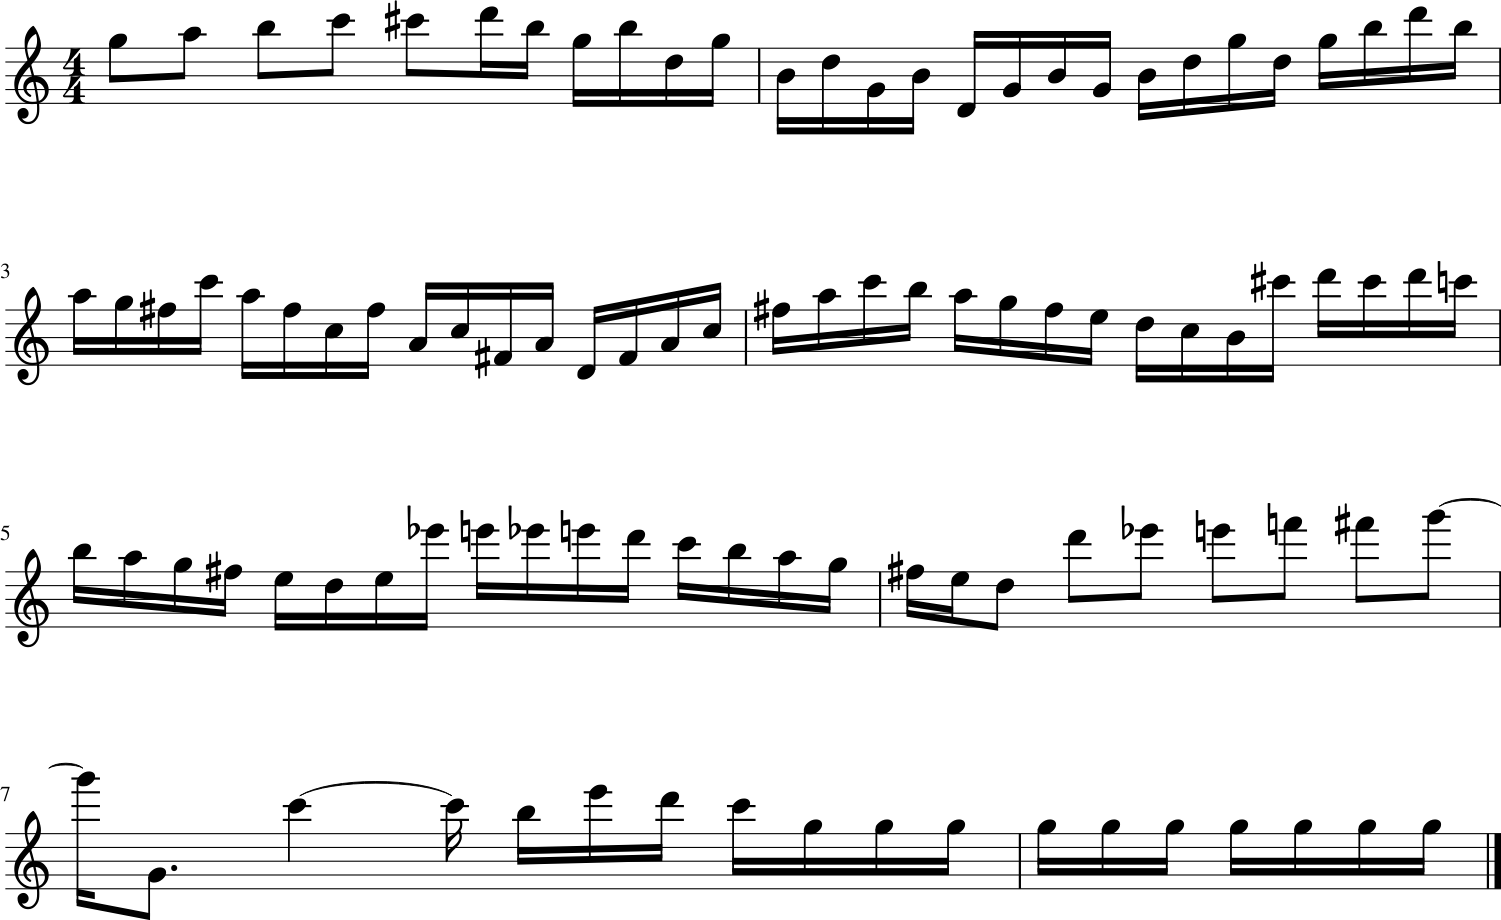

In [172]:
sc.show()

In [173]:
from music21 import *
from datetime import datetime
filename = "gerada_" + datetime.now().strftime("%Y%m%d-%H%M%S"+".mid")

In [174]:
mf = midi.translate.streamToMidiFile(sc)
mf.open(filename, 'wb')
mf.write()
mf.close()

In [175]:
filename

'gerada_20180609-032511.mid'